## PCS5024 - Aprendizado Estatístico
 - Primeiro trimestre 2023 
 - Profs. Anna Helena Realli Costa e Fábio Gagliardi Cozman 
 - Aluno: Caio Azevedo - caio.aze@alumni.usp.br
 - Entrega em: 30.03.23

## Trabalho 1 - Descrição
A entregar até 31/3 via edisciplinas: uma folha apenas (frente e verso) em formato pdf, contendo descrição concisa relativa às seguintes atividades:

1) Obtenha a base Adult (por exemplo no UCI Repository or no Kaggle). 

Recomendação: leia sobre o UCI Repository e o Kaggle, são recursos importantes.

2) Analise os atributos, dados faltantes, e características gerais da base Adult, usando ferramentas da sklearn. Selecione atributos, discretize atributos numéricos, processe dados faltantes. Se possível use Jupyter para desenvolver seu trabalho.

3) Construa um classificador para a variável ">50k" da base Adult (ou seja, se a pessoa ganha mais do que US$50k por ano ou não). Use um classificador Nearest Neighbour com seleção de hiperparâmetro via validação cruzada; se preferir, divida a base de treino em duas partes respectivamente para treino e validação. 

5) Apresente acurácia, precisão e revocação do melhor classificador Nearest Neighbour obtido.

6) Ponto extra: teste um classificador Naive Bayes para a mesma variável com os mesmos atributos.

## Objetivo
 - Análise para classificação das pessoas que ganham mais de U$50k por ano. 
 - **Projeto Classificação Binária**

## Sobre o dataset

### Características descritivas
| Data Set Characteristics | Number of Instances | Attribute Characteristics | Number of Attributes | Associated Tasks | Missing Values? 
| --- | --- | --- | --- | --- | --- 
| Multivariate | 48842 | Categorical, Integer | 14 | Classification | Yes 

### Sobre os atributos

- **salary** (target): >50K, <=50K.

- **age**: continuous.
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **fnlwgt**: continuous.
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, - -  - Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **education-num**: continuous.
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- **sex**: Female, Male.
- **capital-gain**: continuous.
- **capital-loss**: continuous.
- **hours-per-week**: continuous.
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

## Referências:
 - https://archive.ics.uci.edu/ml/datasets/adult
 - https://archive.ics.uci.edu/ml/machine-learning-databases/adult/
 - http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html
 - http://www.cs.toronto.edu/~delve/data/adult/desc.html
 - https://www.scaler.com/topics/data-science/categorical-missing-values/ 

 boas implementações
 - https://www.kaggle.com/code/bhupendrarajput/complete-eda-and-machine-learning
 - https://machinelearningmastery.com/imbalanced-classification-with-the-adult-income-dataset/
 - https://arxiv.org/ftp/arxiv/papers/1810/1810.10076.pdf
 - https://github.com/itdxer/adult-dataset-analysis

## Implementação

### Importação bibliotecas

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

In [12]:
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.impute import SimpleImputer
%matplotlib inline

### Constantes

In [33]:
#'https://raw.githubusercontent.com/Bhupendra1770/Adult-Census-Income-Prediction/main/adult.csv'
APP_PATH = os.getcwd()
DATA_DIR = os.path.join(APP_PATH, 'data')
TRAIN_DATA_FILE = os.path.join(DATA_DIR, 'adult.data.csv')
TEST_DATA_FILE = os.path.join(DATA_DIR, 'adult.test.csv')
target_column = "income"

### Leitura e tratamento inicial da amostra

 **Considerações do autor**: 
 - Os arquivos obtidos da url de referência foram divididos em adult.data, contendo **32.561** registros e o arquivo adult.test com 16.281 registros, um total de **48.842** registros. 
 - Para esse estudo, mudei o formato dos arquivos para csv e incluir os nomes das colunas manualmente, conforme descrição do dataset e mantive os arquivos originais na pasta 'data' desse projeto. 
 - Sendo assim, o arquivo adult.data.csv, será utilizado para o treinamento e validação das técnicas de classificação, enquanto que o arquivo adult.test.csv, será utilizada para testar seus respectivos desempenhos.
 **Preprocessamento & análise exploratória dos dados (EDA)**
 - observou-se que não temos atributos preenchidos com null (NaN), no entanto, dados desconhecidos/faltantes estão preenchidos com o caracter '?'
 - para facilitar o tratamento dos dados, por conta dos métodos de tratamento de nulls, substitui o caracter '?' por nulo/NaN

In [75]:
def read_dataset(path):
    return pd.read_csv(
        path,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={              #identificamos que alguns atributos possuem '?'
            'capital_gain': 99999,
            'workclass': '?',
            'native-country': '?',
            'occupation': '?',
        },
    )

def clean_dataset(data):
    # Por algum motivo o dataset de teste tem um ponto (.) no final da coluna salary, sendo necessário remove-lo
    data['salary'] = data.salary.str.rstrip('.')
    
    # Remoção das colunas colunas abaixo, pois entendemos que elas não são 
    # relevantes para classificação.
    data = data.drop('fnlwgt', axis=1)
    data = data.drop('education.num', axis=1)
    data = data.drop('capital-gain', axis=1)
    data = data.drop('capital-loss', axis=1)
    
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binarize target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)

    return data

In [76]:
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
print("Percentual da variável target positivas na amostra de treino: {:.2%}".format(np.mean(train_data.salary)))

Percentual da variável target positivas na amostra de treino: 23.77%


In [77]:
train_data.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,0


In [67]:
df = train_data.copy()

#profile = ProfileReport(df, title="Análise das features da base do Guarujá")
#profile

 - remoção de atributos considerados irrelevantes para análise

In [41]:
#remove eventuais espaços vazios no inicio e/ou fim das colunas do tipo string 'object'
for i in df.columns:
    if df[i].dtype=='object':
        df[i] = df[i].str.strip()

df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K


In [ ]:
df = df.replace('?', np.nan)

In [ ]:
df.info()

In [ ]:
df.shape

<AxesSubplot:>

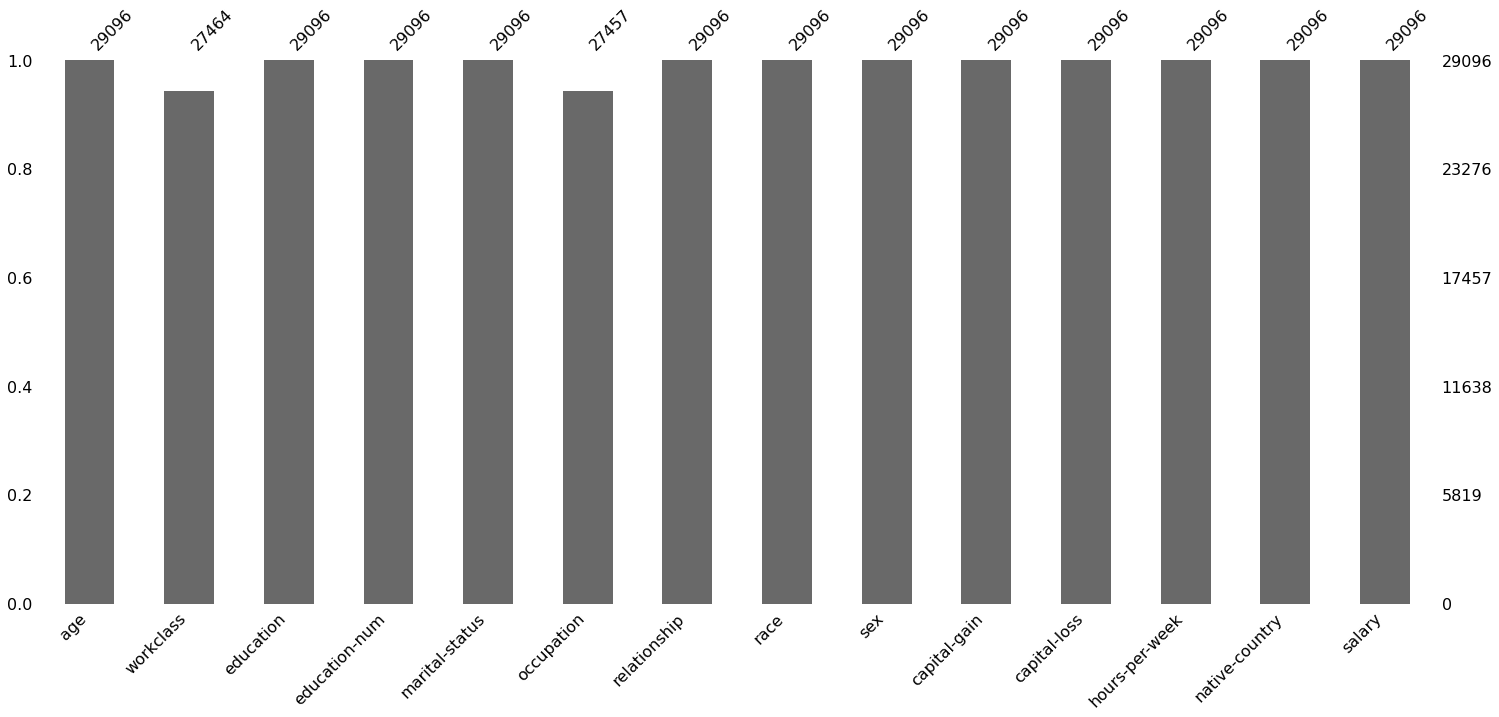

In [69]:
#visualiza a quantidade de registros nulos por atributo
msno.bar(df)

- observa-se que algums colunas estão totalmente preenchidas, por exemplo age, education, race etc. no entanto, outras colunas possuem valor nulo, tais como workclass, occupation e country.

In [70]:
#total de registros nulos por atributo. 
df.isnull().sum()

age                  0
workclass         1632
education            0
education-num        0
marital-status       0
occupation        1639
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
salary               0
dtype: int64

### Tratando dados faltantes
 - optaremos por três abordagens para o tratamento dos dados faltantes, visto que todos eles são categoricos.
 1. remoção dos registros que possuam pelo menos um dado faltante.
 2. preencher os dados faltantes pelo mais frequente na amostra (moda)
 3. preencher os dados faltantes por meio de um modelo de classificação (RandomForest ou LogistcRegression)
 
 - as abordagens 2 e 3 foram consideradas, uma vez que somente menos que 1% (30162/32561) da amostra possui dados faltantes.
 - para efeito de classificação, será considerada a abordagem que resultar no melhor desempenho dos modelos utilizados

In [ ]:
#dropnulls | most_frequent | 
lang = "nada"

match lang:
    case "dropnulls":
        #df.dropna(axis=0, inplace=True)
        df.isnull().sum()
        print("nulos apagados")

    case "most_frequent":
        impute_mode = SimpleImputer(strategy = 'most_frequent')
        impute_mode.fit(df[['workclass', 'occupation','native-country']])
        df[['workclass', 'occupation','native-country']] = impute_mode.transform(df[['workclass', 'occupation','native-country']])
        print("nulos preenchidos com os registros mais frequentes")

    case _:
        print("nenhuma das opções válidas")

#### remoção dos registros (linhas)

In [ ]:
#df.dropna(axis=0, inplace=True)
df.isnull().sum()

In [ ]:
df.shape

 - **2399** de 32561 registros excluídos da amostra

#### dados faltantes com os mais frequentes

In [ ]:
impute_mode = SimpleImputer(strategy = 'most_frequent')
impute_mode.fit(df[['workclass', 'occupation','native-country']])
df[['workclass', 'occupation','native-country']] = impute_mode.transform(df[['workclass', 'occupation','native-country']])

In [ ]:
df.isnull().sum()

In [ ]:
df.shape

- nenhum registro excluído da amostra, todos os dados faltantes substituidos pelo mais frequente. 

#### dados faltantes com um modelo de classificação

In [ ]:
# To perform KNN imputation, we need to normalize the input data and perform One Hot Encoding to categorical variables
#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors = 3)
#df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [ ]:
#X = df.drop("workclass", axis=1).values
#Y = df["workclass"].values

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [ ]:
#forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, max_features=0.6, min_samples_leaf=3, n_jobs=-1)
#forest.fit(X_train, Y_train)

### Transformação da coluna target (salary)

 - optamos por atribuir 0 para os salários <= 50k e 1 para os maiores que 50k

In [ ]:
#codificação da coluna target, salario, para classificação binária.
df['salary']=df['salary'].replace('<=50K',0)
df['salary']=df['salary'].replace('>50K',1)

### Explorando relação da variável target e os demais atributos

In [ ]:
#increasing default charts dimensions
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
#Distribuição dos salários da amostra (percebe-se que ela está, sob esse critério, desbalanceada)
ax = sns.countplot(x="salary", data=df, palette="Blues_d")
plt.subplots_adjust(bottom=0.4)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.35, p.get_height()+2))
plt.ylabel('Frequência')
plt.show()

In [ ]:
#checking male and female ration according to their salary
class_sex = pd.crosstab(df['salary'],df['sex'])
class_sex.plot(kind='bar')

In [ ]:
sns.barplot(x="sex",y="tip",data=tips, hue='day',capsize=.02)

In [ ]:
sns.histplot(x="workclass",data=df, bins=15, kde=False, hue='salary')

In [ ]:
df_salary_view = df.copy()
df_salary_view = df_salary_view.groupby('salary').agg(['mean','sum']) #,'std', 'max', 'min'

In [ ]:
df_view = df_salary_view.melt(ignore_index=False,var_name=['Variável','Estatística']).reset_index()
df_view

In [ ]:
var_names = df_view['Variável'].unique()

In [ ]:
fig, ax = plt.subplots(len(var_names),1, figsize=(10, 30), );
for i,j in enumerate(var_names):
    if (j == 'workclass') | (j == 'education') | (j == 'race') | (j == 'relationship'):
        ax[i].set_title('sum')
        ESTATISTIC = 'sum'
    else:
        ax[i].set_title('mean')
        ESTATISTIC = 'mean'
    sns.barplot(data=df_view[(df_view['Estatística'] == ESTATISTIC) & (df_view['Variável'] == j)], 
                x='salary', 
                y='value', 
                ax=ax[i])
    ax[i].grid(True)
    if i < len(var_names)-1:
        ax[i].set_xlabel('')
    ax[i].set_ylabel(j)
plt.show()

In [ ]:
#categorical columns
cat_col=[]
for i in df.columns:
    if df[i].dtype=='object':
        cat_col.append(i)
        
cat_col  

In [ ]:
# categorical columns
plt.suptitle('Univariate Analysis of Categorical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i in range(0, len(cat_col)):
    plt.figure(figsize=(40, 50))
    plt.subplot(8, 3, i+1)
    #sns.countplot(x=df[cat_col[i]])
    #plt.xlabel(cat_col[i])
    #plt.xticks(rotation=45)
    #plt.tight_layout()
    ax = sns.countplot(x=df[cat_col[i]], data=df, palette="Blues_d")
    plt.subplots_adjust(bottom=0.4)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x()+0.35, p.get_height()+2))
    plt.xticks(rotation=45)
    plt.xlabel(cat_col[i])
    plt.ylabel('Frequência')
    plt.tight_layout()
    #plt.show()

In [ ]:
plt.suptitle('Univariate Analysis of Categorical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i in range(0, len(cat_col)):
    class_salary = pd.crosstab(df['salary'],df[cat_col[i]])
    class_salary.plot(kind='bar')
    #plt.subplots_adjust(bottom=0.4)
    #for p in ax.patches:
    #    ax.annotate(str(p.get_height()), (p.get_x()+0.35, p.get_height()+2))
    plt.xticks(rotation=0)
    plt.xlabel(cat_col[i])
    plt.ylabel('Frequência')
    plt.tight_layout()
    #plt.show()

 
 - Dados desbalanceados quanto a variável target com 7841 registros acima de 50k (24% do total) e 24720 abaixo.
 - Os homens são maioria independente da faixa salarial, embora sua proporção seja maior entre aqueles que ganham acima de 50K. Os trabalhadores alocados na iniciativa privata são a maioria da amostra de treino, com 74% do total, e os que concentram os maiores salários.
 - Os maiores salários estão entre aqueles dedicados à iniciativa privada, com maior grau de instrução (Graduatos, Doutores e mestres, embora tenhamos uma parcela significativa que apenas concluiram o ensino fundamental). Também estão nessa categoria os casados e maridos, brancos e oriundos dos EUA.

In [ ]:
#numeric columns
num_col=[]
for i in df.columns:
    if df[i].dtype=='int64':
        num_col.append(i)

num_col = num_col[0:2]
num_col

In [ ]:
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(num_col)):
    plt.subplot(5, 3, i+1)
    sns.kdeplot(x=df[num_col[i]],shade=True, color='b')
    plt.xlabel(num_col[i])
    plt.tight_layout()

### Check Multicollinearity for Categorical features
- A chi-squared test (also chi-square or χ2 test) is a statistical hypothesis test that is valid to perform when the test statistic is chi-squared distributed under the null hypothesis, specifically Pearson's chi-squared test
- A chi-square statistic is one way to show a relationship between two categorical variables.
- Here we test correlation of Categorical columns with Target column i.e Salary

In [ ]:
from scipy.stats import chi2_contingency
chi2_test = []
for feature in df[cat_col]:
    if chi2_contingency(pd.crosstab(df['salary'], df[feature]))[1] < 0.05:
        chi2_test.append('Reject Null Hypothesis')
    else:
        chi2_test.append('Fail to Reject Null Hypothesis')
result = pd.DataFrame(data=[cat_col, chi2_test]).T
result.columns = ['Column', 'Hypothesis Result']
result

Checking outliers

In [ ]:
plt.figure(figsize=(10,40))
for i in range(0,len(num_col)):
    plt.subplot(5, 2, i+1)
    sns.boxplot(data=df[num_col[i]])
    plt.xlabel(num_col[i])

so we can see that to many outliers are there so we have to treat them before going to model building

### Treating outliers

In [ ]:
# Function to detect outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


## function to remove outliers
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = dataframe[variable].mean()
        dataframe.loc[(dataframe[variable] > up_limit), variable] = dataframe[variable].mean()

In [ ]:
replace_with_thresholds(df,num_col)

In [ ]:
plt.figure(figsize=(10,40))
for i in range(0,len(num_col)):
    plt.subplot(5, 2, i+1)
    sns.boxplot(data=df[num_col[i]])
    plt.xlabel(num_col[i])

## Modelando os classificadores

creating a new copy of dataset(df) and convert it into numerical with the help of labelEncoder

In [ ]:
new_df = df.copy()
new_df.head()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
#data.drop('salary',axis=1,inplace=True)

from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)
data_categorical = data[categorical_columns]
data_categorical.head()


data_encoded = encoder.fit_transform(data_categorical)

a = pd.DataFrame(data_encoded,columns=['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'country','salary'])
b = data[['age','hours-per-week']]
#c=data['hours-per-week']
new_df = pd.concat([b,a],axis=1)

In [ ]:
new_df

In [ ]:
new_df.shape

Dependent and Independent features

In [ ]:
X = new_df.iloc[:,:-1]
y = new_df.iloc[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=7,test_size=0.33)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

SVC

In [ ]:
svc = SVC().fit(X_train,y_train)

In [ ]:
svc.score(X_train,y_train)

In [ ]:
svc_pred = svc.predict(X_test)
accuracy_score(y_test,svc_pred)

Hyperparameter Tunning

In [ ]:
params = dict(kernel=['linear', 'poly'],C=[1,0.1,0.01])
Grid_model = GridSearchCV(svc,params,n_jobs=-1)
Grid_model.fit(X_train,y_train)
Grid_model.best_params_

In [ ]:
best_model = SVC(kernel='poly',gamma='scale',C=1).fit(X_train,y_train)

In [ ]:
best_model.score(X_train,y_train)

In [ ]:
best_pred = best_model.predict(X_test)

In [ ]:
accuracy_score(y_test,best_pred)